In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [2]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 99% 777M/788M [00:19<00:00, 34.3MB/s]
100% 788M/788M [00:19<00:00, 42.4MB/s]


In [3]:
!unzip -qq microsoft-catsvsdogs-dataset.zip

# Load Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import cv2 as cv
import numpy as np
import random
import os

import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm

# Folder Management

In [5]:
for i in os.listdir('PetImages/Cat'):
  os.rename(f'PetImages/Cat/{i}', f'PetImages/Cat/cat{i}')

for i in os.listdir('PetImages/Dog'):
  os.rename(f'PetImages/Dog/{i}', f'PetImages/Dog/dog{i}')

!mv PetImages/Cat/* PetImages/
!mv PetImages/Dog/* PetImages/
!rmdir PetImages/Cat
!rmdir PetImages/Dog

In [7]:
!mkdir /content/pet320

In [ ]:
# Convert all images shape (320, 320, 3)
base_list = os.listdir('PetImages')

for i in tqdm(base_list):
  try:
    img = cv.imread('/content/PetImages/' + i)
    img = cv.resize(img, (320, 320))
    #print(img.shape)
    cv.imwrite(f'/content/pet320/{i}', img)
  except Exception as e:
    print(e)

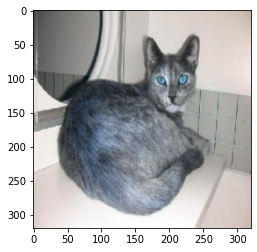

In [31]:
img = cv.imread('pet320/cat30.jpg', cv.IMREAD_ANYCOLOR)
plt.imshow(img)

# Data Loader

In [2]:
class SSDataLoader:
  def __init__(self, folder, batchsize=64):
    self.folder = folder
    self.bsize = batchsize
    self.batch_out = batchsize

    # High and Low res sizes
    self.limsize = (160, 160)

    # List images
    imglist = os.listdir(folder)
    random.shuffle(imglist)

    # Find max batch
    self.max_ = len(imglist) // self.bsize

    # Drop surplus imgs from list
    self.imglist = imglist[:self.max_].copy()

    # Declare start and end
    self.start = 0
    self.end = self.start + self.bsize
  

  def reset(self) -> None:
    self.start = 0
    self.end = 0
    random.shuffle(self.imglist)


  def __iter__(self):
    return self


  def __next__(self):
    # Slice batch
    batch = self.imglist[self.start:(self.start+self.bsize)]
    
    if len(batch) == 0:
      raise StopIteration

    # Update start and end
    self.start += self.bsize
    self.end = self.start + self.bsize
    
    channel_R = []
    channel_G = []
    channel_B = []
    
    label_R = []
    label_G = []
    label_B = []

    for i in batch:
      # Read and resize images
      img = cv.imread(f'{self.folder}/{i}', cv.IMREAD_ANYCOLOR)
      if img is None:
        continue
      
      img = img / 255.0
      #print(img.shape)

      # Create input and label images
      img_input = cv.resize(img, self.limsize)
      im_R = img_input[:, :, 2]
      im_G = img_input[:, :, 1]
      im_B = img_input[:, :, 0]
      #print(im_R.shape)

      img_label = img.copy()
      out_R = img_label[:, :, 2]
      out_G = img_label[:, :, 1]
      out_B = img_label[:, :, 0]
      
      # Add to the lists
      if im_R.shape == (160, 160):
        channel_R.append(im_R)
        channel_G.append(im_G)
        channel_B.append(im_B)

        label_R.append(out_R)
        label_G.append(out_G)
        label_B.append(out_B)
    
    # Convert pytorch Tensor
    featuresR = np.array(channel_R, dtype=np.float32)
    featuresR = np.reshape(featuresR, (-1, 1, 160, 160))
    featuresR = torch.Tensor(featuresR)

    featuresG = np.array(channel_G, dtype=np.float32)
    featuresG = np.reshape(featuresG, (-1, 1, 160, 160))
    featuresG = torch.Tensor(featuresG)

    featuresB = np.array(channel_B, dtype=np.float32)
    featuresB = np.reshape(featuresB, (-1, 1, 160, 160))
    featuresB = torch.Tensor(featuresB)

    labelR = np.array(label_R, dtype=np.float32)
    labelR = np.reshape(labelR, (-1, 1, 320, 320))
    labelR = torch.Tensor(labelR)

    labelG = np.array(label_G, dtype=np.float32)
    labelG = np.reshape(labelG, (-1, 1, 320, 320))
    labelG = torch.Tensor(labelG)

    labelB = np.array(label_B, dtype=np.float32)
    labelB = np.reshape(labelB, (-1, 1, 320, 320))
    labelB = torch.Tensor(labelB)

    self.batch_out = featuresR.shape[0]

    return featuresR, featuresG, featuresB, labelR, labelG, labelB
    


data_loader = SSDataLoader('pet320', batchsize=32)

In [3]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        # (W - F + P) / stride + 1 
        nn.Conv2d(1, 64, kernel_size=2, stride=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, kernel_size=2, stride=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
    )
    self.decoder = nn.Sequential(      
        
        nn.ConvTranspose2d(128, 1, kernel_size=6, stride=2, padding=0, bias=False),
        nn.BatchNorm2d(1),
        nn.LeakyReLU(0.2, inplace=True)
    )
  
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [4]:
ch_R = AutoEncoder() 
ch_G = AutoEncoder()
ch_B = AutoEncoder()

In [21]:
NUM_EPOCH = 10
LEARNING_RATE = 1e-3
criterion = nn.MSELoss()
optimizerR = optim.Adam(ch_R.parameters(), lr=LEARNING_RATE)
optimizerG = optim.Adam(ch_G.parameters(), lr=LEARNING_RATE)
optimizerB = optim.Adam(ch_B.parameters(), lr=LEARNING_RATE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


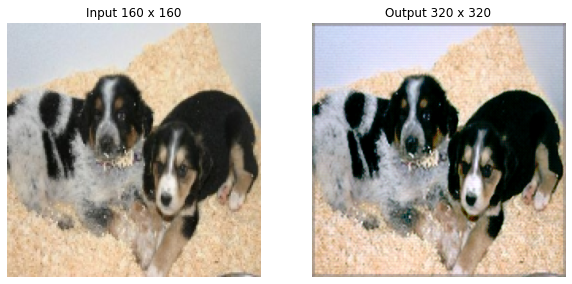

In [22]:
for epoch in range(NUM_EPOCH):
  data_loader.reset()
  for i in range(data_loader.max_):
    try:
      dataR, dataG, dataB, labelR, labelG, labelB = data_loader.__next__()
    except StopIteration:
      continue
    
    # Model output
    outR = ch_R(dataR)
    outG = ch_G(dataG)
    outB = ch_B(dataB)

    # Calculate loss
    lossR = criterion(outR, labelR)
    lossG = criterion(outG, labelG)
    lossB = criterion(outB, labelB)

    lossR.backward()
    lossG.backward()
    lossB.backward()
    
    # Update params
    optimizerR.step()
    optimizerG.step()
    optimizerB.step()

    
    # Make zero grad
    optimizerR.zero_grad()
    optimizerG.zero_grad()
    optimizerB.zero_grad()

    #print(f'Epoch : {epoch+1} -> R : {lossR:.4} G : {lossG:.4} B : {lossB:.4}')
    
    display.clear_output(wait=True)

    fig = plt.figure(figsize=(10,8))
    
    imR = dataR.detach().numpy()[0]
    imG = dataG.detach().numpy()[0]
    imB = dataB.detach().numpy()[0]
    img_input = np.zeros((160, 160, 3))
    img_input[:, :, 0] = imR.reshape((160, 160))
    img_input[:, :, 1] = imG.reshape((160, 160))
    img_input[:, :, 2] = imB.reshape((160, 160))

    fig.add_subplot(1, 2, 1)
    plt.imshow(img_input)
    plt.axis('off')
    plt.title("Input 160 x 160")

    lbR = outR.detach().numpy()[0]
    lbG = outG.detach().numpy()[0]
    lbB = outB.detach().numpy()[0]
    img_out = np.zeros((320, 320, 3))
    img_out[:, :, 0] = lbR.reshape((320, 320))
    img_out[:, :, 1] = lbG.reshape((320, 320))
    img_out[:, :, 2] = lbB.reshape((320, 320))
    
    fig.add_subplot(1, 2, 2)
    plt.imshow(img_out)
    plt.axis('off')
    plt.title("Output 320 x 320")

    plt.show()